In [74]:
import torch
from torch import nn
from torch.nn import functional as F
from torchvision.utils import make_grid
import matplotlib.pyplot as plt


In [62]:
class VAE(nn.Module):

    def __init__(self,input_dim,h_dim=200,z_dim=20):
        super().__init__()
        #encoder
        self.img_2_hid = nn.Linear(input_dim,h_dim)
        self.hid_2_mu = nn.Linear(h_dim,z_dim)
        self.hid_2_logvar = nn.Linear(h_dim,z_dim)
        #decoder
        self.z_2_hid = nn.Linear(z_dim,h_dim)   
        self.hid_2_img = nn.Linear(h_dim,input_dim)
        self.relu = nn.ReLU()

    def encode(self,x):
        h = self.relu(self.img_2_hid(x))
        mu = self.hid_2_mu(h)
        logvar = self.hid_2_logvar(h)
        return mu,logvar
    
    def decode(self,z):
        h = self.relu(self.z_2_hid(z))
        return torch.sigmoid(self.hid_2_img(h))
    
    def forward(self,x):
        mu,logvar = self.encode(x)
        epsilion = torch.randn_like(logvar)
        std= torch.exp(.5*logvar)
        z_reparametrizied = mu+std*epsilion
        x_reconstructed = self.decode(z_reparametrizied)

        return x_reconstructed,mu,logvar



In [63]:
vae = VAE(20*20)
x,mu,sigma = vae(torch.randn(5,20*20))

In [64]:
import torchvision.datasets as datasets
from tqdm import tqdm
from torchvision import transforms
from torchvision.utils import save_image
from torch.utils.data import DataLoader

In [65]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
INPUT_DIM = 784
H_DIM = 200
Z_DIM = 15
EPOCHS = 20
BATCH_SIZE = 64
LR = 2e-4

In [66]:
dataset = datasets.MNIST(root='dataset/',train=True,transform=transforms.ToTensor(),download=True)
train_loader = DataLoader(dataset,batch_size=BATCH_SIZE,shuffle=True)
model = VAE(INPUT_DIM,H_DIM,Z_DIM).to(device)
optimizer = torch.optim.Adam(model.parameters(),lr=LR)
criterion = nn.BCELoss(reduction='sum')

In [ ]:
for epoch in range(EPOCHS):
    model.train()
    model.to(device)
    beta = min(1.0,epoch/10)
    for input,_ in tqdm(train_loader):
        input = input.to(device)

        input = input.view(input.size(0),-1)
        reconstructed_input ,mu,sigma = model(input)

        reconstructed_loss = criterion(reconstructed_input,input)
        kl_div = -.5*torch.sum(1+sigma-mu.pow(2)-sigma.exp()) # formula
        kl_div = kl_div/input.size(0)
        loss = reconstructed_loss+kl_div*beta

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    print(f'loss: {loss.item()}')        

In [ ]:
# def inference(model,digit=None,num_samples=1):
#     model = model.to('cpu')
#     model.eval()

#     if digit is not None:
#         img = next(x for x,y in dataset if y ==digit)
#         img = img.view(1,784)
#         with torch.no_grad():
#             mu,logvar=model.encode(img)

#     else:
#         mu =torch.zeros(1,model.hid_2_mu.out_features)
#         logvar=torch.zeros_like(mu)

#     std = torch.exp(.5*logvar)
#     eps =torch.randn(num_samples,std.size(1))
#     z = mu +std*eps

#     with torch.no_grad():
#         out = model.decode(z)
    
#     out = out.view(num_samples,1,28,28)
#     save_image(out,f'generated_digit_{digit}.png')

#     print(f"saved  {num_samples} samples for digit {digit}")

# inference(model,num_samples=200)

saved  200 samples for digit None


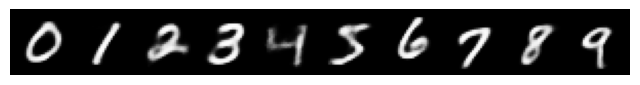

In [95]:
model.eval()
model.to(device)
samples = []
for digit in range(10):
    img = next(x for x, y in dataset if y==digit)
    img=img.view(1,-1).to(device)

    with torch.no_grad():
        mu,logvar = model.encode(img)
        std = torch.exp(.5*logvar)
        eps = torch.randn_like(std)
        z=mu+eps*std
        out = model.decode(z)

    out = out.view(1,1,28,28).to('cpu')
    samples.append(out)

samples =torch.cat(samples,dim=0)
grid=make_grid(samples,nrow=10,normalize=True)

plt.figure(figsize=(8,6))
plt.imshow(grid.permute(1,2,0))
plt.axis('off')
plt.show()